# Demand Forecasting using Non-Parametric technique.
I this project I build a forecasting model using supervised machine learning approach.
I framed the time series problem as a regression problem and employed LightGBM model to forecast the sales for the next (3) months given 5 years of sales recorded on different items in diffrent stores.

* Loaded the data and checked the quality of the data.
* Check for randomness of the data using lag plot.
* Visualize the full time series data.
* Performed some exploratory data analysis and feature engineering on the data.
* Split the data into train and test set
* Configure the parameters of lightGBM 
* fit and tune the model
* Make forescast for the next (3) months for 50 different items in 10 different stores.
* Save the model in serialzed form for future development.


In [1]:
# my custom function
import smape_metrics
%matplotlib inline

import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['figure.figsize'] = (12, 7)

from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and Check Data Quality

In [2]:
train= pd.read_csv('data/demand-forecasting-kernels-only/train.csv')
test= pd.read_csv('data/demand-forecasting-kernels-only/test.csv')

In [3]:
train['date'] = pd.to_datetime(train['date'],)
train['item'] = train['item'].astype('category')

In [71]:
all_data = pd.concat([train, test])

In [72]:
def inspect(data):
    print('head')
    print(data.head(),'\n')
    "---------------"
    print('tail', '\n')
    print(data.tail())
    "----------------"
    
    print('data information', '\n')
    print(data.info())
    

In [73]:
inspect(all_data)

head
                  date  store  item  sales  id
0  2013-01-01 00:00:00      1     1   13.0 NaN
1  2013-01-02 00:00:00      1     1   11.0 NaN
2  2013-01-03 00:00:00      1     1   14.0 NaN
3  2013-01-04 00:00:00      1     1   13.0 NaN
4  2013-01-05 00:00:00      1     1   10.0 NaN 

tail 

             date  store  item  sales       id
44995  2018-03-27     10    50    NaN  44995.0
44996  2018-03-28     10    50    NaN  44996.0
44997  2018-03-29     10    50    NaN  44997.0
44998  2018-03-30     10    50    NaN  44998.0
44999  2018-03-31     10    50    NaN  44999.0
data information 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    958000 non-null  object 
 1   store   958000 non-null  int64  
 2   item    958000 non-null  int64  
 3   sales   913000 non-null  float64
 4   id      45000 non-null   float64
dtypes: float64(2), int64(2)

In [74]:
print("Number of unique store: ", all_data['store'].nunique())
print("Number of unique item: ", all_data['item'].nunique())

Number of unique store:  10
Number of unique item:  50


In [75]:
all_data['date'] = pd.to_datetime(all_data['date'])

In [76]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [77]:
all_data.describe([0.1, 0.25, 0.5, .75, .95]).round(2)

,store,item,sales,id
count,958000.00,958000.00,913000.00,45000.00
mean,5.50,25.50,52.25,22499.50
std,2.87,14.43,28.80,12990.53
min,1.00,1.00,0.00,0.00
10%,1.90,5.90,20.00,4499.90
25%,3.00,13.00,30.00,11249.75
50%,5.50,25.50,47.00,22499.50
75%,8.00,38.00,70.00,33749.25
95%,10.00,48.00,107.00,42749.05
max,10.00,50.00,231.00,44999.00


.

# Check for Randomness and Correlations

In [78]:
all_data.set_index('date', inplace=True)

In [79]:
all_data.head()

,store,item,sales,id
date,,,,
2013-01-01,1,1,13.0,NaN
2013-01-02,1,1,11.0,NaN
2013-01-03,1,1,14.0,NaN
2013-01-04,1,1,13.0,NaN
2013-01-05,1,1,10.0,NaN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'lag plot')

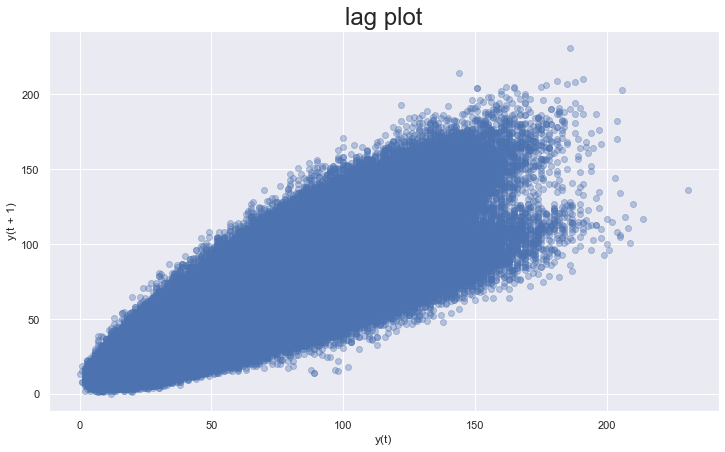

In [80]:
lag_plot(all_data['sales'], alpha=.35,)
plt.title('lag plot', size=24)

The **data is random if the lag plot shows not visible shape.**
Here we can see that the data we are using is not random because we can see it shows a specific shape.
And also the lags shows a very high correlation.
All this can be seen in the lag plot

<AxesSubplot:xlabel='date'>

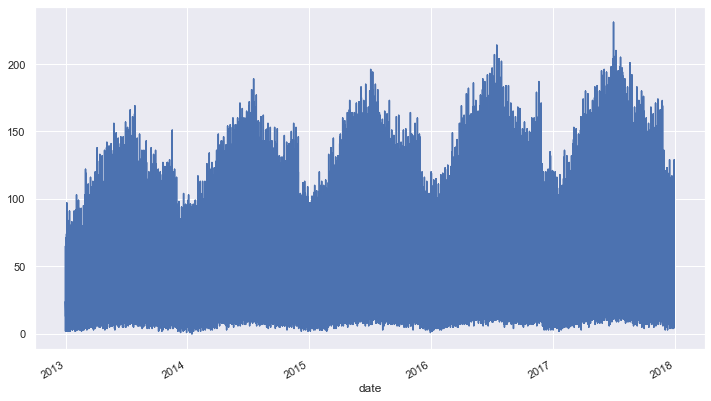

In [81]:
all_data['sales'].plot()

.

# Exploratory Data Analysis

In [82]:
# distinct items in each store
all_data.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [83]:
all_data.groupby(['store', 'item'])['sales'].agg(['min', 'max', 'mean', 'sum'])

min    max       mean       sum
store item                                  
1     1      4.0   50.0  19.971522   36468.0
      2     13.0  115.0  53.148959   97050.0
      3      8.0   70.0  33.208105   60638.0
      4      4.0   43.0  19.956188   36440.0
      5      3.0   37.0  16.612815   30335.0
...          ...    ...        ...       ...
10    46    23.0  125.0  66.046550  120601.0
      47     6.0   56.0  24.755750   45204.0
      48    21.0  120.0  57.814896  105570.0
      49     6.0   69.0  33.032311   60317.0
      50    24.0  150.0  74.037240  135192.0

[500 rows x 4 columns]

.

# Creating Data Related Features

In [84]:
# creating new columns

def create_date_features(df):
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['day of week'] = df['date'].dt.dayofweek
    df['is weekend'] = df['date'].dt.dayofweek // 4
    df['days in month'] = df['date'].dt.days_in_month
    df['is month start'] = df['date'].dt.is_month_start.astype(int)
    df['is month end'] = df['date'].dt.is_month_end.astype(int)
    
    return df   

In [86]:
all_data.reset_index(inplace=True)
all_df = create_date_features(all_data)

In [87]:
all_df

,date,store,item,sales,id,year,month,quarter,day of week,is weekend,days in month,is month start,is month end
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,0,31,1,0
1,2013-01-02,1,1,11.0,NaN,2013,1,1,2,0,31,0,0
2,2013-01-03,1,1,14.0,NaN,2013,1,1,3,0,31,0,0
3,2013-01-04,1,1,13.0,NaN,2013,1,1,4,1,31,0,0
4,2013-01-05,1,1,10.0,NaN,2013,1,1,5,1,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
957995,2018-03-27,10,50,NaN,44995.0,2018,3,1,1,0,31,0,0
957996,2018-03-28,10,50,NaN,44996.0,2018,3,1,2,0,31,0,0
957997,2018-03-29,10,50,NaN,44997.0,2018,3,1,3,0,31,0,0
957998,2018-03-30,10,50,NaN,44998.0,2018,3,1,4,1,31,0,0


In [88]:
all_df.set_index('date', inplace=True)

In [89]:
all_df.head()

,store,item,sales,id,year,month,quarter,day of week,is weekend,days in month,is month start,is month end
date,,,,,,,,,,,,
2013-01-01,1,1,13.0,NaN,2013,1,1,1,0,31,1,0
2013-01-02,1,1,11.0,NaN,2013,1,1,2,0,31,0,0
2013-01-03,1,1,14.0,NaN,2013,1,1,3,0,31,0,0
2013-01-04,1,1,13.0,NaN,2013,1,1,4,1,31,0,0
2013-01-05,1,1,10.0,NaN,2013,1,1,5,1,31,0,0


In [90]:
all_df.groupby(['store', 'item', 'year', 'month'])['sales'].agg(['min', 'max', 'mean', 'sum'])

min    max       mean     sum
store item year month                                
1     1    2013 1       5.0   18.0  10.580645   328.0
                2       7.0   21.0  11.500000   322.0
                3      10.0   22.0  15.387097   477.0
                4       9.0   26.0  17.400000   522.0
                5       7.0   27.0  17.129032   531.0
...                     ...    ...        ...     ...
10    50   2017 11     62.0  123.0  85.800000  2574.0
                12     41.0   86.0  64.096774  1987.0
           2018 1       NaN    NaN        NaN     0.0
                2       NaN    NaN        NaN     0.0
                3       NaN    NaN        NaN     0.0

[31500 rows x 4 columns]

In [91]:
all_df.groupby(['store', 'item', 'year', 'quarter'])['sales'].agg(['min', 'max', 'mean', 'sum']).round(2)

min    max   mean     sum
store item year quarter                            
1     1    2013 1         5.0   22.0  12.52  1127.0
                2         7.0   38.0  18.46  1680.0
                3         8.0   34.0  19.28  1774.0
                4         5.0   31.0  15.70  1444.0
           2014 1         4.0   31.0  15.43  1389.0
...                       ...    ...    ...     ...
10    50   2017 1        32.0   93.0  63.98  5758.0
                2        54.0  150.0  95.27  8670.0
                3        59.0  143.0  95.26  8764.0
                4        41.0  123.0  76.83  7068.0
           2018 1         NaN    NaN    NaN     0.0

[10500 rows x 4 columns]

.

# Creating Lag Features

In [92]:
# creating lag features
def create_lags(dataframe, lags, colname):
    for lag in lags:
        dataframe[colname+'-lag-'+str(lag)] = dataframe.groupby(['store', 'item'])['sales'].shift(lag)
        
    return dataframe

In [93]:
all_df = create_lags(all_df, lags= [5, 10, 12, 16, 32, 34, 40, 60, 72], colname='sales')

In [94]:
all_df

,store,item,sales,id,year,month,quarter,day of week,is weekend,days in month,...,is month end,sales-lag-5,sales-lag-10,sales-lag-12,sales-lag-16,sales-lag-32,sales-lag-34,sales-lag-40,sales-lag-60,sales-lag-72
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13.0,NaN,2013,1,1,1,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,1,11.0,NaN,2013,1,1,2,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1,14.0,NaN,2013,1,1,3,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1,13.0,NaN,2013,1,1,4,1,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1,10.0,NaN,2013,1,1,5,1,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,10,50,NaN,44995.0,2018,3,1,1,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-28,10,50,NaN,44996.0,2018,3,1,2,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-29,10,50,NaN,44997.0,2018,3,1,3,0,31,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# creating rolling mean features
def rollmean_feature(dataframe, window):
    for w in window:
        dataframe['sales_roll_mean_'+str(w)] = dataframe.\
        groupby(['store', 'item'])['sales'].shift(1).rolling(window= w, min_periods = 10).mean()
    return dataframe

In [96]:
all_df = rollmean_feature(all_df, window=[80, 90, 100, 112, 180, 200, 256, 300, 365, 400, 410, 420, 456, 460, 500])

In [97]:
all_df

,store,item,sales,id,year,month,quarter,day of week,is weekend,days in month,...,sales_roll_mean_200,sales_roll_mean_256,sales_roll_mean_300,sales_roll_mean_365,sales_roll_mean_400,sales_roll_mean_410,sales_roll_mean_420,sales_roll_mean_456,sales_roll_mean_460,sales_roll_mean_500
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13.0,NaN,2013,1,1,1,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,1,11.0,NaN,2013,1,1,2,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1,14.0,NaN,2013,1,1,3,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1,13.0,NaN,2013,1,1,4,1,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1,10.0,NaN,2013,1,1,5,1,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,10,50,NaN,44995.0,2018,3,1,1,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-28,10,50,NaN,44996.0,2018,3,1,2,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-29,10,50,NaN,44997.0,2018,3,1,3,0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# I then encode the categorical columns
all_df = pd.get_dummies(all_df, columns=['store', 'item', 'year', 'month', 'quarter', 'day of week'])

In [99]:
all_df

,sales,id,is weekend,days in month,is month start,is month end,sales-lag-5,sales-lag-10,sales-lag-12,sales-lag-16,...,quarter_2,quarter_3,quarter_4,day of week_0,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.0,NaN,0,31,1,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,11.0,NaN,0,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,14.0,NaN,0,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,13.0,NaN,1,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,10.0,NaN,1,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,NaN,44995.0,0,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2018-03-28,NaN,44996.0,0,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2018-03-29,NaN,44997.0,0,31,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


In [100]:
list(all_df)

['sales',
 'id',
 'is weekend',
 'days in month',
 'is month start',
 'is month end',
 'sales-lag-5',
 'sales-lag-10',
 'sales-lag-12',
 'sales-lag-16',
 'sales-lag-32',
 'sales-lag-34',
 'sales-lag-40',
 'sales-lag-60',
 'sales-lag-72',
 'sales_roll_mean_80',
 'sales_roll_mean_90',
 'sales_roll_mean_100',
 'sales_roll_mean_112',
 'sales_roll_mean_180',
 'sales_roll_mean_200',
 'sales_roll_mean_256',
 'sales_roll_mean_300',
 'sales_roll_mean_365',
 'sales_roll_mean_400',
 'sales_roll_mean_410',
 'sales_roll_mean_420',
 'sales_roll_mean_456',
 'sales_roll_mean_460',
 'sales_roll_mean_500',
 'store_1',
 'store_2',
 'store_3',
 'store_4',
 'store_5',
 'store_6',
 'store_7',
 'store_8',
 'store_9',
 'store_10',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'item_6',
 'item_7',
 'item_8',
 'item_9',
 'item_10',
 'item_11',
 'item_12',
 'item_13',
 'item_14',
 'item_15',
 'item_16',
 'item_17',
 'item_18',
 'item_19',
 'item_20',
 'item_21',
 'item_22',
 'item_23',
 'item_24',
 'it

.

# Split the Data into Train and Test set, then fit LightGBM model

In [50]:
# now we create train and test set
# and fit the data to our model..

In [101]:
train_set = all_df.loc['2013-01-01': '2017-12-31']
test_set= all_df.loc['2018-01-01': '2018-03-31']

train_target = train_set['sales']
test_target= test_set['sales']

In [102]:
print('No. of train set: ', train_set.shape[0])
print('No. of test set: ', test_set.shape[0])
print('\n')
print('Shape of train set: ', train_set.shape)
print('Shape of test set: ', test_set.shape)

No. of train set:  913000
No. of test set:  45000


Shape of train set:  (913000, 119)
Shape of test set:  (45000, 119)


In [103]:
len(list(train_set))

119

In [104]:
list(train_set)[2:]

['is weekend',
 'days in month',
 'is month start',
 'is month end',
 'sales-lag-5',
 'sales-lag-10',
 'sales-lag-12',
 'sales-lag-16',
 'sales-lag-32',
 'sales-lag-34',
 'sales-lag-40',
 'sales-lag-60',
 'sales-lag-72',
 'sales_roll_mean_80',
 'sales_roll_mean_90',
 'sales_roll_mean_100',
 'sales_roll_mean_112',
 'sales_roll_mean_180',
 'sales_roll_mean_200',
 'sales_roll_mean_256',
 'sales_roll_mean_300',
 'sales_roll_mean_365',
 'sales_roll_mean_400',
 'sales_roll_mean_410',
 'sales_roll_mean_420',
 'sales_roll_mean_456',
 'sales_roll_mean_460',
 'sales_roll_mean_500',
 'store_1',
 'store_2',
 'store_3',
 'store_4',
 'store_5',
 'store_6',
 'store_7',
 'store_8',
 'store_9',
 'store_10',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'item_6',
 'item_7',
 'item_8',
 'item_9',
 'item_10',
 'item_11',
 'item_12',
 'item_13',
 'item_14',
 'item_15',
 'item_16',
 'item_17',
 'item_18',
 'item_19',
 'item_20',
 'item_21',
 'item_22',
 'item_23',
 'item_24',
 'item_25',
 'item_26

In [106]:
X_col = list(train_set)[2:]
y_col= ['sales']

X_train = train_set[X_col]
X_test =test_set[X_col]

y_train = train_set[y_col]
y_test = test_set[y_col]

.

## Configure the LightGBM to the data.

In [107]:
# initialize the dataset

# setting up the train  lightGBM algorithm
l_train = lgb.Dataset(
                      data=X_train, # independent variables
                      label=y_train, # target variables
                      feature_name=X_col # column names 
)
# setting up the test for the lightGBM algorithm
l_test = lgb.Dataset( 
                     data=X_test, 
                     label=y_test, 
                     reference=l_train, # validation data
                     feature_name=X_col
)

# setting parameters..
# using **Mean Absolute Deviation** to evaluate the Model..
params = {
          'metric':'mae', 
          'num_leaves':20, 
          'learning_rate':0.001,
          'max_depth': 200,
          'num_boost_round': 1000 # epochs
         }

# perfrom training
model = lgb.train( 
                   params=params,
                   train_set=l_train, 
                   valid_sets=[l_train, l_test], 
                 )


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5730
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 116
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 52.250287
[1]	training's l1: 23.1423	valid_1's l1: 52.2178
[2]	training's l1: 23.1222	valid_1's l1: 52.1854
[3]	training's l1: 23.1022	valid_1's l1: 52.153
[4]	training's l1: 23.0821	valid_1's l1: 52.1207
[5]	training's l1: 23.0622	valid_1's l1: 52.0884
[6]	training's l1: 23.0422	valid_1's l1: 52.0561
[7]	training's l1: 23.0222	valid_1's l1: 52.0238
[8]	training's l1: 23.0023	valid_1's l1: 51.9916
[9]	training's l1: 22.9823	valid_1's 

[155]	training's l1: 20.3085	valid_1's l1: 47.5211
[156]	training's l1: 20.2916	valid_1's l1: 47.4923
[157]	training's l1: 20.2747	valid_1's l1: 47.4617
[158]	training's l1: 20.2579	valid_1's l1: 47.4313
[159]	training's l1: 20.2411	valid_1's l1: 47.4027
[160]	training's l1: 20.2243	valid_1's l1: 47.3721
[161]	training's l1: 20.2075	valid_1's l1: 47.345
[162]	training's l1: 20.1908	valid_1's l1: 47.3164
[163]	training's l1: 20.1741	valid_1's l1: 47.286
[164]	training's l1: 20.1573	valid_1's l1: 47.2575
[165]	training's l1: 20.1406	valid_1's l1: 47.2271
[166]	training's l1: 20.1239	valid_1's l1: 47.2
[167]	training's l1: 20.1072	valid_1's l1: 47.1715
[168]	training's l1: 20.0906	valid_1's l1: 47.1412
[169]	training's l1: 20.0741	valid_1's l1: 47.1137
[170]	training's l1: 20.0574	valid_1's l1: 47.0854
[171]	training's l1: 20.0409	valid_1's l1: 47.0552
[172]	training's l1: 20.0243	valid_1's l1: 47.0252
[173]	training's l1: 20.0077	valid_1's l1: 46.9969
[174]	training's l1: 19.9912	valid_1

[318]	training's l1: 17.8019	valid_1's l1: 43.0618
[319]	training's l1: 17.7879	valid_1's l1: 43.0366
[320]	training's l1: 17.7739	valid_1's l1: 43.0101
[321]	training's l1: 17.7599	valid_1's l1: 42.985
[322]	training's l1: 17.746	valid_1's l1: 42.9624
[323]	training's l1: 17.7322	valid_1's l1: 42.9374
[324]	training's l1: 17.7182	valid_1's l1: 42.911
[325]	training's l1: 17.7043	valid_1's l1: 42.886
[326]	training's l1: 17.6904	valid_1's l1: 42.8626
[327]	training's l1: 17.6767	valid_1's l1: 42.8376
[328]	training's l1: 17.6628	valid_1's l1: 42.8113
[329]	training's l1: 17.6489	valid_1's l1: 42.7865
[330]	training's l1: 17.635	valid_1's l1: 42.764
[331]	training's l1: 17.6213	valid_1's l1: 42.7392
[332]	training's l1: 17.6074	valid_1's l1: 42.7129
[333]	training's l1: 17.5936	valid_1's l1: 42.6882
[334]	training's l1: 17.5799	valid_1's l1: 42.6642
[335]	training's l1: 17.5661	valid_1's l1: 42.638
[336]	training's l1: 17.5525	valid_1's l1: 42.6133
[337]	training's l1: 17.5387	valid_1's

[481]	training's l1: 15.7228	valid_1's l1: 39.2549
[482]	training's l1: 15.7112	valid_1's l1: 39.2344
[483]	training's l1: 15.6996	valid_1's l1: 39.2112
[484]	training's l1: 15.6881	valid_1's l1: 39.1895
[485]	training's l1: 15.6766	valid_1's l1: 39.1678
[486]	training's l1: 15.6649	valid_1's l1: 39.1489
[487]	training's l1: 15.6536	valid_1's l1: 39.1287
[488]	training's l1: 15.6422	valid_1's l1: 39.107
[489]	training's l1: 15.6306	valid_1's l1: 39.0881
[490]	training's l1: 15.6191	valid_1's l1: 39.0665
[491]	training's l1: 15.6076	valid_1's l1: 39.0473
[492]	training's l1: 15.5961	valid_1's l1: 39.0257
[493]	training's l1: 15.5846	valid_1's l1: 39.0028
[494]	training's l1: 15.5733	valid_1's l1: 38.9813
[495]	training's l1: 15.562	valid_1's l1: 38.9608
[496]	training's l1: 15.5504	valid_1's l1: 38.942
[497]	training's l1: 15.539	valid_1's l1: 38.9205
[498]	training's l1: 15.5275	valid_1's l1: 38.9017
[499]	training's l1: 15.5163	valid_1's l1: 38.8817
[500]	training's l1: 15.505	valid_1

[643]	training's l1: 13.9904	valid_1's l1: 36.1997
[644]	training's l1: 13.9808	valid_1's l1: 36.1807
[645]	training's l1: 13.971	valid_1's l1: 36.1654
[646]	training's l1: 13.9611	valid_1's l1: 36.1494
[647]	training's l1: 13.9514	valid_1's l1: 36.1315
[648]	training's l1: 13.9417	valid_1's l1: 36.115
[649]	training's l1: 13.9319	valid_1's l1: 36.1
[650]	training's l1: 13.9224	valid_1's l1: 36.0812
[651]	training's l1: 13.9127	valid_1's l1: 36.0648
[652]	training's l1: 13.9029	valid_1's l1: 36.0491
[653]	training's l1: 13.8933	valid_1's l1: 36.0303
[654]	training's l1: 13.8836	valid_1's l1: 36.0149
[655]	training's l1: 13.8738	valid_1's l1: 35.9992
[656]	training's l1: 13.8641	valid_1's l1: 35.9839
[657]	training's l1: 13.8545	valid_1's l1: 35.9675
[658]	training's l1: 13.8449	valid_1's l1: 35.9488
[659]	training's l1: 13.8353	valid_1's l1: 35.9325
[660]	training's l1: 13.8256	valid_1's l1: 35.9169
[661]	training's l1: 13.8161	valid_1's l1: 35.8993
[662]	training's l1: 13.8065	valid_1

[805]	training's l1: 12.544	valid_1's l1: 33.7135
[806]	training's l1: 12.5358	valid_1's l1: 33.6995
[807]	training's l1: 12.5275	valid_1's l1: 33.686
[808]	training's l1: 12.5195	valid_1's l1: 33.6732
[809]	training's l1: 12.5114	valid_1's l1: 33.6592
[810]	training's l1: 12.5031	valid_1's l1: 33.646
[811]	training's l1: 12.4951	valid_1's l1: 33.6326
[812]	training's l1: 12.4871	valid_1's l1: 33.6195
[813]	training's l1: 12.4789	valid_1's l1: 33.6057
[814]	training's l1: 12.4708	valid_1's l1: 33.5918
[815]	training's l1: 12.4626	valid_1's l1: 33.578
[816]	training's l1: 12.4547	valid_1's l1: 33.5653
[817]	training's l1: 12.4465	valid_1's l1: 33.5521
[818]	training's l1: 12.4385	valid_1's l1: 33.5382
[819]	training's l1: 12.4306	valid_1's l1: 33.5252
[820]	training's l1: 12.4224	valid_1's l1: 33.512
[821]	training's l1: 12.4144	valid_1's l1: 33.4983
[822]	training's l1: 12.4064	valid_1's l1: 33.4852
[823]	training's l1: 12.3983	valid_1's l1: 33.4716
[824]	training's l1: 12.3903	valid_1

[968]	training's l1: 11.3323	valid_1's l1: 31.6343
[969]	training's l1: 11.3256	valid_1's l1: 31.622
[970]	training's l1: 11.3189	valid_1's l1: 31.6112
[971]	training's l1: 11.3122	valid_1's l1: 31.5992
[972]	training's l1: 11.3055	valid_1's l1: 31.5851
[973]	training's l1: 11.2989	valid_1's l1: 31.5737
[974]	training's l1: 11.2922	valid_1's l1: 31.5624
[975]	training's l1: 11.2854	valid_1's l1: 31.5513
[976]	training's l1: 11.2787	valid_1's l1: 31.5389
[977]	training's l1: 11.2721	valid_1's l1: 31.5275
[978]	training's l1: 11.2655	valid_1's l1: 31.5135
[979]	training's l1: 11.2587	valid_1's l1: 31.5026
[980]	training's l1: 11.252	valid_1's l1: 31.4887
[981]	training's l1: 11.2454	valid_1's l1: 31.4772
[982]	training's l1: 11.2387	valid_1's l1: 31.4674
[983]	training's l1: 11.2321	valid_1's l1: 31.455
[984]	training's l1: 11.2255	valid_1's l1: 31.4433
[985]	training's l1: 11.2189	valid_1's l1: 31.4294
[986]	training's l1: 11.2122	valid_1's l1: 31.4171
[987]	training's l1: 11.2057	valid

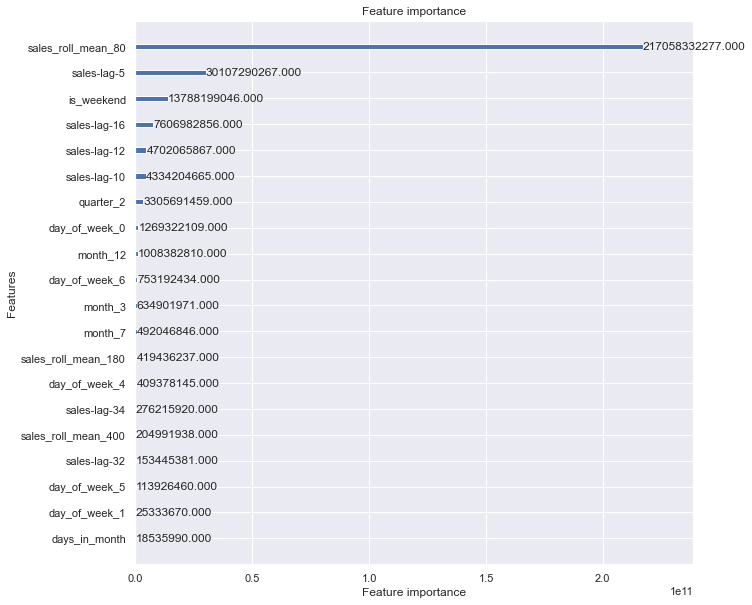

In [108]:
lgb.plot_importance(
                    model, 
                    max_num_features=20, 
                    importance_type='gain', 
                    figsize=(10, 10)
                   )
plt.show()

.

# Forecast

In [109]:
F = model.predict(X_test)
forecast = pd.DataFrame(F, index= X_test.index, columns=['forecast for the next (3) months'])
vars_ = test[['store', 'item']]
vars_.index = forecast.index

F_DF = pd.concat([vars_, forecast], axis=1)

.

# Forecast for the next (3) months

In [117]:
F_DF

,store,item,forecast for the next (3) months
date,,,
2018-01-01,1,1,47.311723
2018-01-02,1,1,46.822358
2018-01-03,1,1,46.776038
2018-01-04,1,1,48.471720
2018-01-05,1,1,53.618812
...,...,...,...
2018-03-27,10,50,30.384851
2018-03-28,10,50,30.384851
2018-03-29,10,50,30.384851


In [112]:
F_DF.to_csv('forecast.csv')

In [120]:
all_data[['store', 'item', 'sales']].to_excel('data/demand_data.xlsx')